댓글 수집 진행 중: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


추출된 명사: ['수입', '기후', '농사', '기후', '농업', '인구', '부가', '가치', '산업', '소수', '효율', '게', '우리', '농업', '우수', '필요', '이웃', '보급', '박수', '수고', '감사', '한국', '농업', '기술', '글로벌', '확산', '아프리카', '기아', '문제', '해결', '기여', '감사', '농촌', '흥청', '르', '카', '전수', '농업', '기술', '영원', '발전', '기원', '아프리카', '가나', '농촌', '흥청', '농업', '기술', '무궁', '발전', '기원', '식량', '문제', '어려움', '아프리카', '농업', '기술', '전파', '감사', '아프리카', '농업', '기술', '대륙', '기적', '쌀', '노벨', '농업', '분야', '상', '신설', '초대', '수상자', '선정', '기원', '한국', '농업', '산업', '도움', '중국', '일본', '자본', '과', '자원', '산업', '도움', '한국', '자랑', '때', '중국', '과', '일본', '그', '자원', '수익', '중', '아프리카', '차', '공업', '산업', '발전']


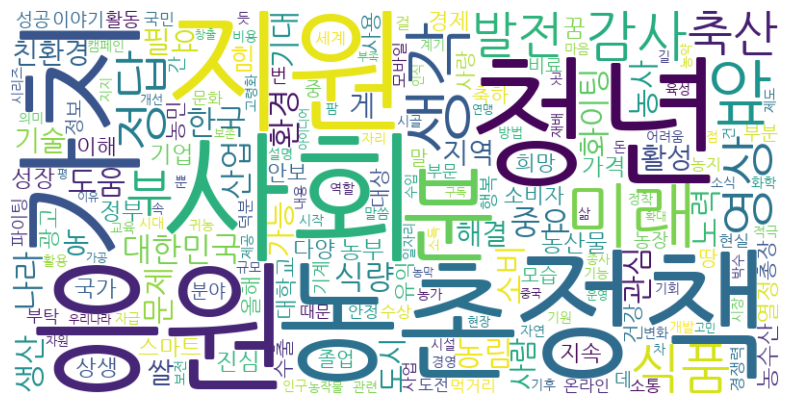

In [ ]:
import requests
import re
import csv
import pandas as pd
from googleapiclient.discovery import build
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tqdm import tqdm
from konlpy.tag import Mecab
from collections import Counter
from googleapiclient.errors import HttpError
import emoji
from dotenv import loadenv
import os
loadenv()
# 유튜브 API 키 설정
api_key = os.getenv('YOUTUBE_API') 

# 유튜브 클라이언트 생성
youtube = build('youtube', 'v3', developerKey=api_key)

def search_videos(query, max_results=10):
    video_ids = []
    request = youtube.search().list(
        part='snippet',
        q=query,
        type='video',
        maxResults=50  # 한 번에 최대 50개의 결과를 요청
    )
    
    while len(video_ids) < max_results:
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['id']['videoId'])
            if len(video_ids) >= max_results:
                break
        
        if 'nextPageToken' in response and len(video_ids) < max_results:
            request = youtube.search().list(
                part='snippet',
                q=query,
                type='video',
                maxResults=50,
                pageToken=response['nextPageToken']
            )
        else:
            break
    
    return video_ids

def get_video_comments(video_id):
    comments = []
    try:
        request = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            maxResults=100
        )
        response = request.execute()

        while response:
            for item in response['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)
            
            if 'nextPageToken' in response:
                request = youtube.commentThreads().list(
                    part='snippet',
                    videoId=video_id,
                    pageToken=response['nextPageToken'],
                    maxResults=100
                )
                response = request.execute()
            else:
                break
    except HttpError as e:
        print(f"An HTTP error {e.resp.status} occurred: {e.content}")
    
    return comments

def filter_comments(comments, keywords):
    filtered_comments = []
    for comment in comments:
        if any(keyword in comment for keyword in keywords):
            filtered_comments.append(comment)
    return filtered_comments

def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = set(file.read().split())
    return stopwords

def clean_text(text):
    """Clean text by removing HTML tags, special characters, and emojis."""
    text = re.sub(r'<[^>]+>', '', text)  # HTML 태그 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    text = re.sub(r'[^가-힣\s]', '', text)  # 한글 및 공백을 제외한 문자 제거
    text = re.sub(r'\s+', ' ', text)  # 연속된 공백을 하나의 공백으로 변경
    text = emoji.replace_emoji(text, replace='')  # 이모티콘 제거
    return text

def main():
    # 검색할 키워드와 동영상 개수 입력받기
    query = input("검색할 키워드를 입력하세요: ")
    max_results = int(input("검색할 동영상 개수를 입력하세요: "))
    
    # 입력받은 키워드로 동영상 검색
    video_ids = search_videos(query, max_results=max_results)

    # 모든 동영상의 댓글 수집 및 필터링
    all_comments = []
    keywords = [query]  # 필터링할 키워드 리스트에 입력받은 키워드 추가
    
    for video_id in tqdm(video_ids, desc="댓글 수집 진행 중"):
        comments = get_video_comments(video_id)
        filtered_comments = filter_comments(comments, keywords)
        all_comments.extend(filtered_comments)

    # 데이터프레임 생성
    df = pd.DataFrame(all_comments, columns=['comment'])

    # 형태소 분석기를 사용해 명사 추출
    mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
    nouns = []
    for comment in df['comment']:
        cleaned_comment = clean_text(comment)
        nouns.extend(mecab.nouns(cleaned_comment))
    
    # 형태소 분석 결과 확인
    print(f"추출된 명사: {nouns[:100]}")  # 상위 100개의 명사 출력

    # 불용어 목록 파일에서 불러오기
    stopwords_path = 'stopwords-ko.txt'
    korean_stopwords = load_stopwords(stopwords_path)

    # 불용어 제거
    filtered_nouns = [noun for noun in nouns if noun not in korean_stopwords]

    # 명사 빈도수 계산
    noun_counts = Counter(filtered_nouns)
    noun_df = pd.DataFrame(noun_counts.items(), columns=['word', 'count']).sort_values(by='count', ascending=False)

    # 수집된 명사 데이터 저장
    noun_df.to_csv('filtered_youtube_comments_nouns.csv', index=False)

    # 모든 명사를 하나의 문자열로 결합
    text = ' '.join(noun_df['word'])

    # 한글 폰트 경로 설정 (다운로드 받은 나눔고딕 폰트 경로)
    font_path = 'NanumGothic.ttf'

    # 제외할 단어 설정
    stopwords = set(STOPWORDS)
    stopwords.update(keywords)  # 필터링한 키워드를 제외 단어로 추가
    stopwords.update(korean_stopwords)  # 불용어 목록에 추가

    # 워드 클라우드 생성
    wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white', stopwords=stopwords).generate(text)

    # 워드 클라우드 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()
